## KDD仿真实验

In [89]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import math
from numpy import loadtxt
import torch.utils.data as Data
from sklearn.metrics import mean_squared_error
import utils
from models.clstm import cLSTM, train_model_adam, regularize, ridge_regularize,arrange_input
from Bird_pd_processing import *


print(torch.__version__)
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

%matplotlib

1.7.1
cuda:0
Using matplotlib backend: Qt5Agg


In [2]:
data1 = pd.read_csv("./KDD数据集/beijing_17_18_aq_CO.csv")
data2 = pd.read_csv("./KDD数据集/beijing_17_18_aq_NO2.csv")
data3 = pd.read_csv("./KDD数据集/beijing_17_18_aq_O3.csv")
data4 = pd.read_csv("./KDD数据集/beijing_17_18_aq_PM2.5.csv")
data5 = pd.read_csv("./KDD数据集/beijing_17_18_aq_PM10.csv")
data6 = pd.read_csv("./KDD数据集/beijing_17_18_aq_SO2.csv")
data7 = pd.read_csv("./KDD数据集/beijing_17_18_meo_humidity.csv")
data8 = pd.read_csv("./KDD数据集/beijing_17_18_meo_pressure.csv")
data9 = pd.read_csv("./KDD数据集/beijing_17_18_meo_temperature.csv")
data10 = pd.read_csv("./KDD数据集/beijing_17_18_meo_wind_direction.csv")
data11 = pd.read_csv("./KDD数据集/beijing_17_18_meo_wind_speed.csv")

In [3]:
location_ID = ['Daxing', 'Fengtaihuayuan', 'Fangshan','Huairou','Pinggu','Pingchang', 'Miyun','Tongzhou','Shunyi','Yanqin','Mentougou']
Shuxing_ID = ['CO','NO2','O3','PM2.5','PM10','SO2','Humidity','Pressure','Temperature','Wind Direction','Wind Speed']

In [4]:
data1 = data1[['daxing_aq', 'fengtaihuayuan_aq', 'fangshan_aq','huairou_aq','pinggu_aq','pingchang_aq', 'miyun_aq','tongzhou_aq','shunyi_aq','yanqin_aq','mentougou_aq']]
data2 = data2[['daxing_aq', 'fengtaihuayuan_aq', 'fangshan_aq','huairou_aq','pinggu_aq','pingchang_aq', 'miyun_aq','tongzhou_aq','shunyi_aq','yanqin_aq','mentougou_aq']]
data3 = data3[['daxing_aq', 'fengtaihuayuan_aq', 'fangshan_aq','huairou_aq','pinggu_aq','pingchang_aq', 'miyun_aq','tongzhou_aq','shunyi_aq','yanqin_aq','mentougou_aq']]
data4 = data4[['daxing_aq', 'fengtaihuayuan_aq', 'fangshan_aq','huairou_aq','pinggu_aq','pingchang_aq', 'miyun_aq','tongzhou_aq','shunyi_aq','yanqin_aq','mentougou_aq']]
data5 = data5[['daxing_aq', 'fengtaihuayuan_aq', 'fangshan_aq','huairou_aq','pinggu_aq','pingchang_aq', 'miyun_aq','tongzhou_aq','shunyi_aq','yanqin_aq','mentougou_aq']]
data6 = data6[['daxing_aq', 'fengtaihuayuan_aq', 'fangshan_aq','huairou_aq','pinggu_aq','pingchang_aq', 'miyun_aq','tongzhou_aq','shunyi_aq','yanqin_aq','mentougou_aq']]
data7 = data7[['daxing_meo','fengtai_meo', 'fangshan_meo','huairou_meo','pinggu_meo','pingchang_meo','miyun_meo', 'tongzhou_meo', 'shunyi_meo','yanqing_meo','mentougou_meo' ]
]
data8 = data8[['daxing_meo','fengtai_meo', 'fangshan_meo','huairou_meo','pinggu_meo','pingchang_meo','miyun_meo', 'tongzhou_meo', 'shunyi_meo','yanqing_meo','mentougou_meo' ]
]
data9 = data9[['daxing_meo','fengtai_meo', 'fangshan_meo','huairou_meo','pinggu_meo','pingchang_meo','miyun_meo', 'tongzhou_meo', 'shunyi_meo','yanqing_meo','mentougou_meo' ]
]
data10 = data10[['daxing_meo','fengtai_meo', 'fangshan_meo','huairou_meo','pinggu_meo','pingchang_meo','miyun_meo', 'tongzhou_meo', 'shunyi_meo','yanqing_meo','mentougou_meo' ]
]
data11 = data11[['daxing_meo','fengtai_meo', 'fangshan_meo','huairou_meo','pinggu_meo','pingchang_meo','miyun_meo', 'tongzhou_meo', 'shunyi_meo','yanqing_meo','mentougou_meo' ]
]
Data_AQI = np.column_stack([data1.values, data2.values,  data3.values,  data4.values, data5.values,data6.values ])
Data_Meo = np.column_stack([data7.values, data8.values,  data9.values,  data10.values, data11.values])

In [5]:
Data_all = np.column_stack([Data_AQI, Data_Meo])
Data_all[Data_all>2000] = np.nan
Data_all[Data_all<-2000] = np.nan
Data_all = Data_all[540:,:]
MM = 1.0 - pd.isna(Data_all)

In [6]:
# from sklearn.preprocessing import StandardScaler

# sc_X = StandardScaler()
# Data_all = sc_X.fit_transform(Data_all)
# # C_all = np.concatenate((C_all,C_0), 0)
# # W_all = np.concatenate((W_all,W[i+1]), 0)

# # print(C_all.shape, W_all.shape)

In [7]:
# Data_all = torch.Tensor(Data_all)
# Data_all = F.tanh(Data_all)
# Data_all = Data_all.numpy()

In [8]:
from sklearn import preprocessing
import numpy as np
x = Data_all
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))#默认为范围0~1，拷贝操作
#min_max_scaler = preprocessing.MinMaxScaler(feature_range = (1,3),copy = False)#范围改为1~3，对原数组操作
Data_all_minmax = min_max_scaler.fit_transform(x)
Data_all_minmax

array([[       nan, 0.23255814, 0.01428571, ..., 0.12643678, 0.0625    ,
        0.03246753],
       [0.18947368, 0.01162791, 0.01428571, ..., 0.13793103, 0.1       ,
        0.04545455],
       [0.17894737, 0.20930233, 0.21428571, ..., 0.05747126, 0.1125    ,
        0.11038961],
       ...,
       [0.08421053, 0.11627907, 0.14285714, ..., 0.02298851, 0.25      ,
        0.14285714],
       [0.08421053, 0.11627907, 0.18571429, ..., 0.04597701, 0.1125    ,
        0.03246753],
       [0.10526316, 0.10465116, 0.14285714, ..., 0.03448276, 0.15      ,
        0.14935065]])

In [9]:
Data_all_minmax[pd.isna(Data_all_minmax)] = 0

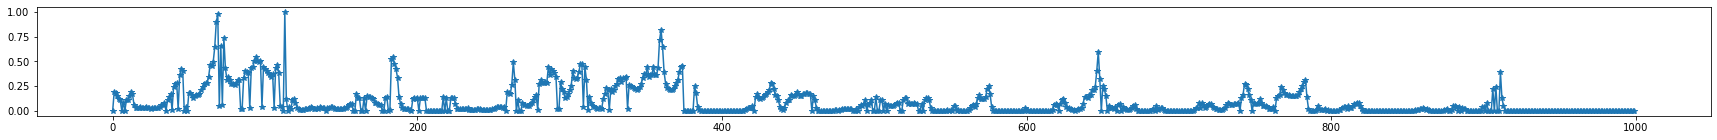

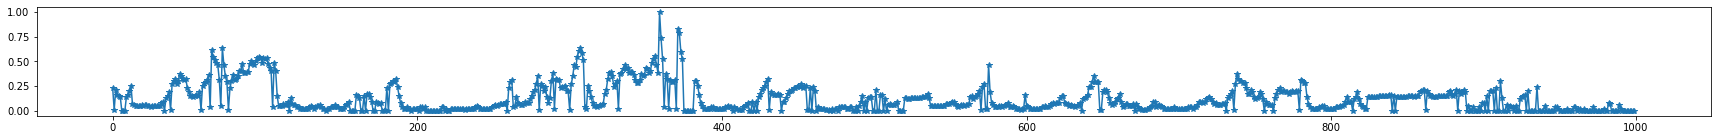

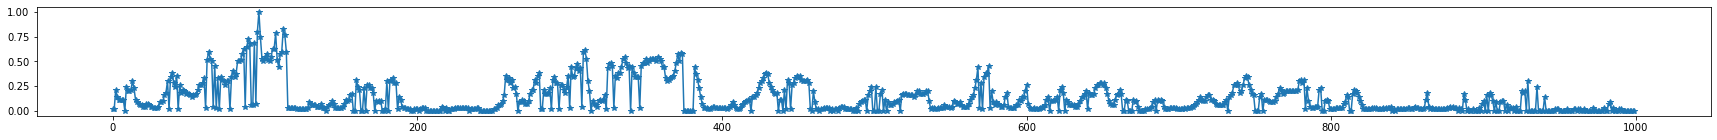

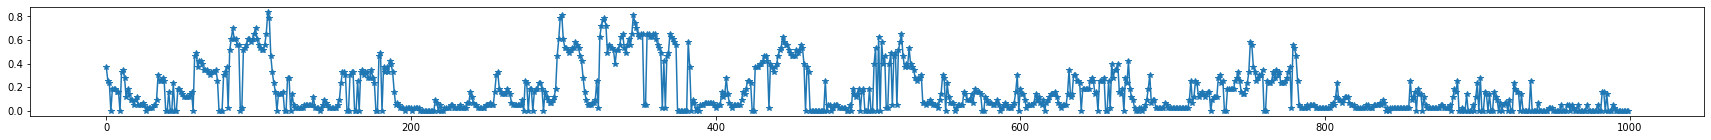

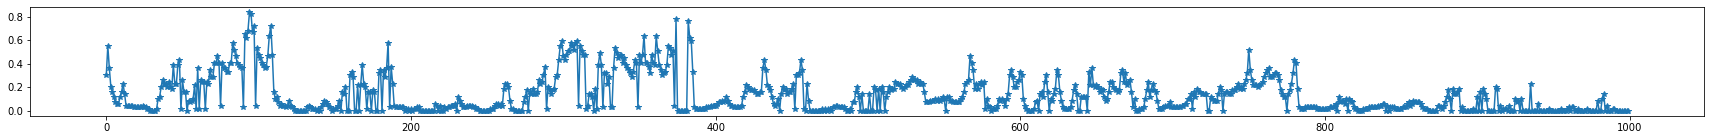

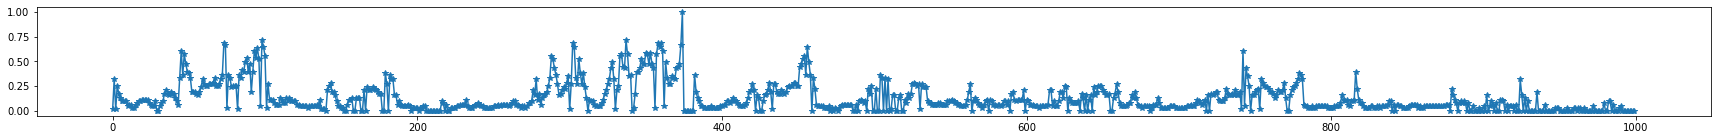

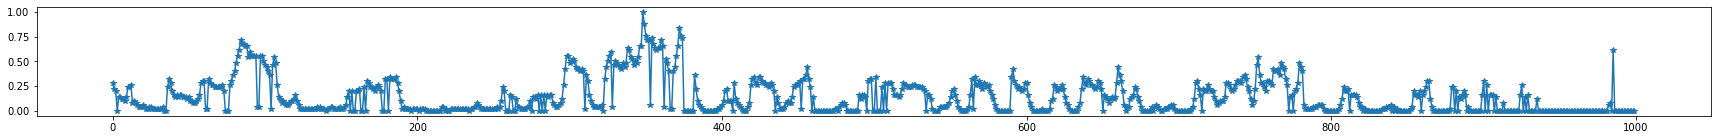

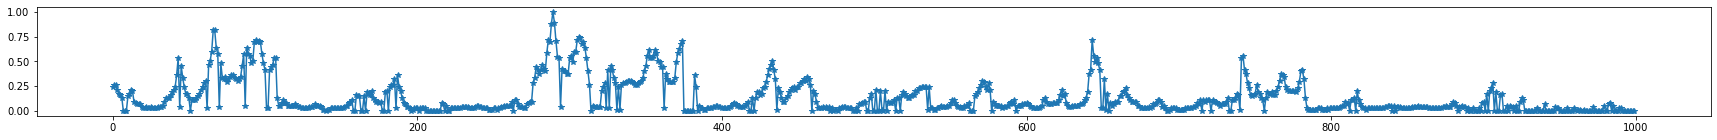

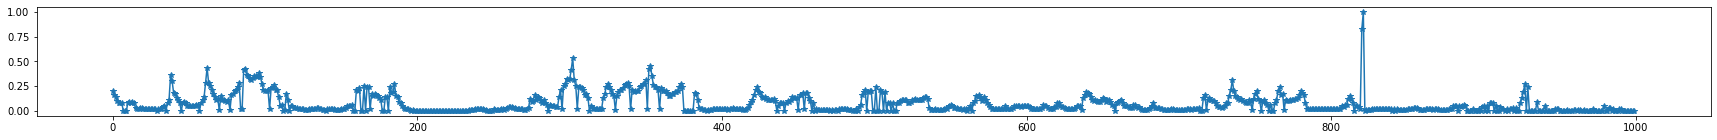

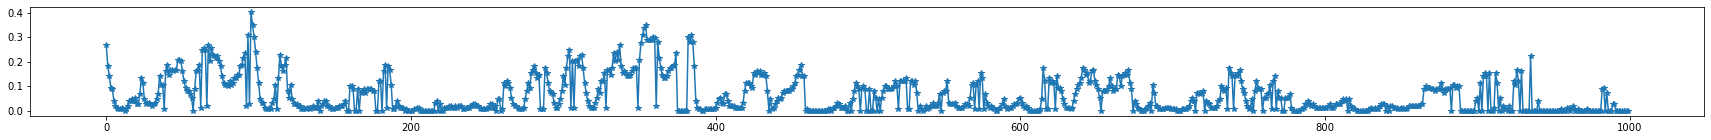

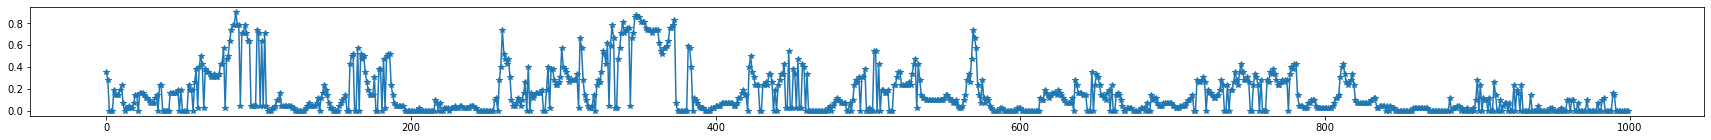

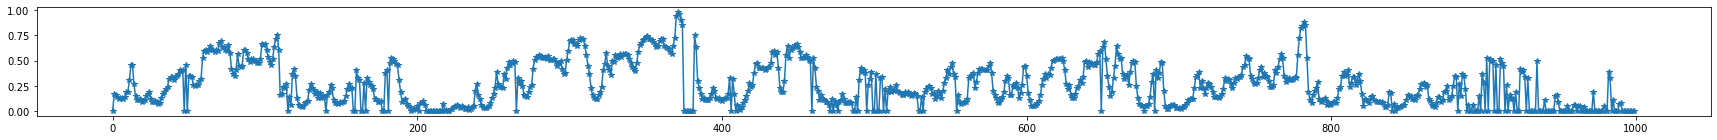

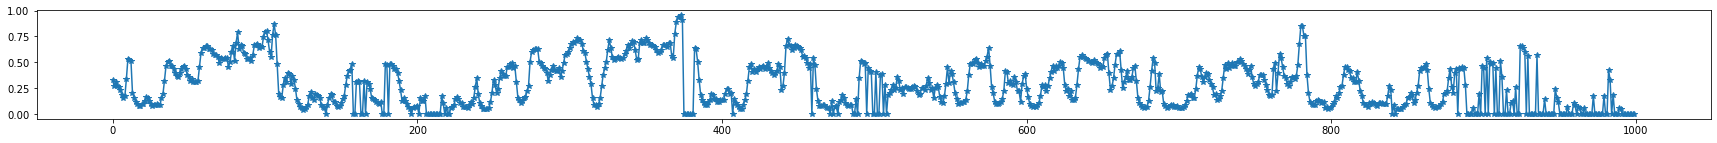

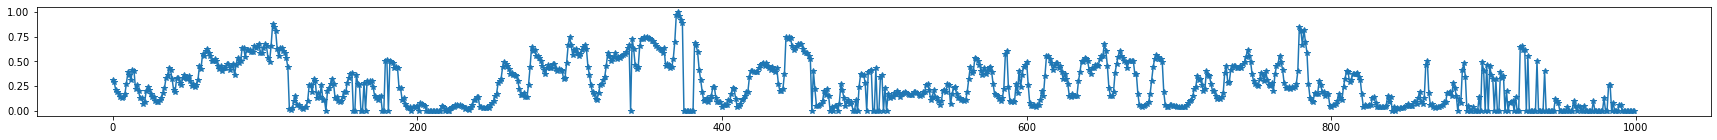

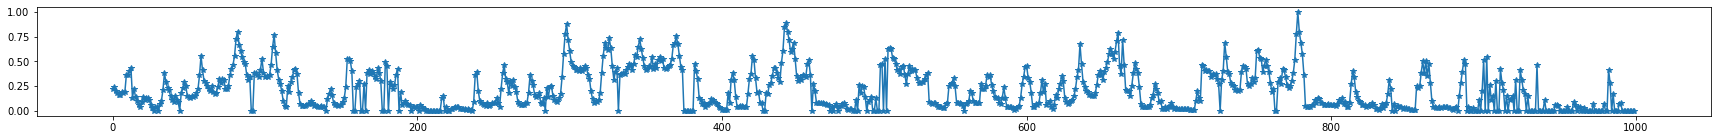

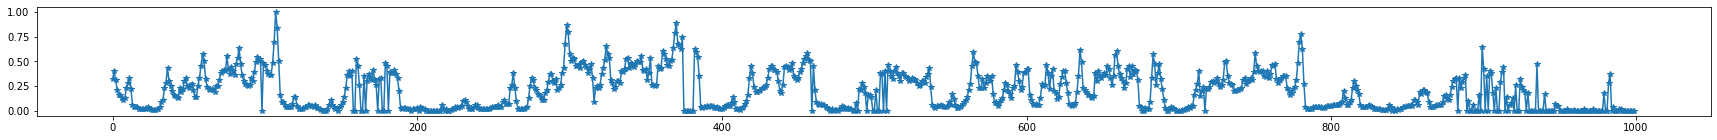

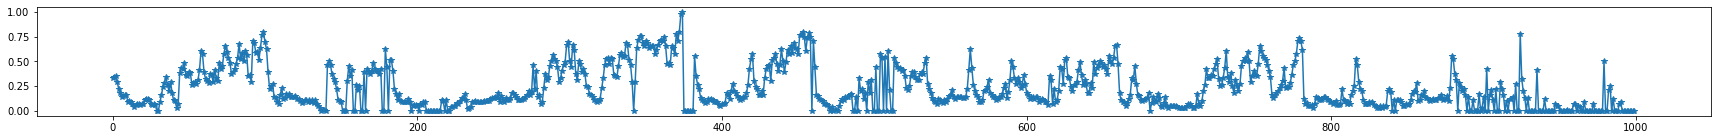

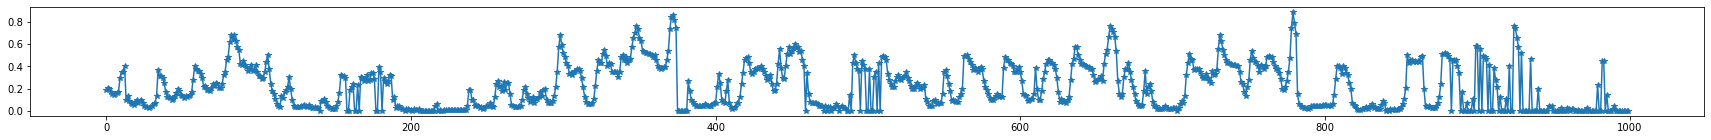

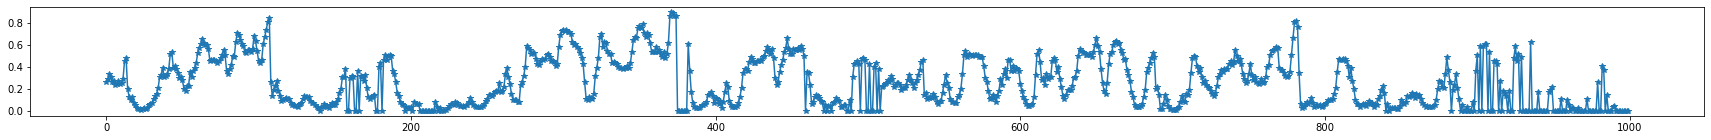

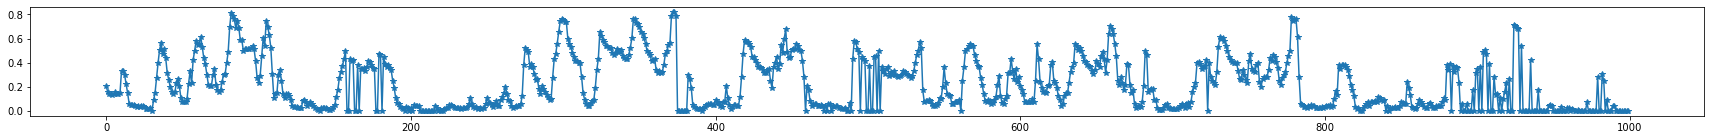

In [10]:
plot_len = 1000
for i_plot_char in range(0,20,1):
    plot_char = i_plot_char
    plot_temp = Data_all_minmax[0:plot_len,plot_char]
    plt.figure(figsize=(30,2))
    plt.plot(range(plot_temp.shape[0]), plot_temp, marker='*')

In [11]:
np.random.seed(0)
time_step=48
in_dim = Data_all.shape[1]
batch_size  = 64
pre_horizon = 48
input_size=time_step
output_size=input_size
Z_size = 30
sample_num = Data_all.shape[0]
EPOCH=10000
LR=1e-3
start_cat = 0*11
end_cat = 11*11
num_cat = end_cat - start_cat
# Prob_drop = 0.2

## 当前每隔1个时间步取一个样本，期望这样能让模型学习一定的知识

In [12]:
data=np.zeros((sample_num,time_step, in_dim),dtype=float)
data_C=np.zeros((sample_num,time_step, in_dim),dtype=float)
data_m=np.zeros((sample_num,time_step, in_dim),dtype=float)
# data_y=np.zeros((sample_num,pre_horizon, in_dim),dtype=float)

# for i in range(0,sample_num-time_step,time_step):
for i in range(0,sample_num-time_step-1,1):
    data[i,:,:]=Data_all_minmax[i:i+time_step,: ]
    data_C[i,:,:]=Data_all_minmax[i+1:i+time_step+1, : ]
    data_m[i,:,:] = MM[i:i+time_step,: ]


## 每隔48小时取一个样本

In [13]:
data=np.zeros((int(sample_num/time_step),time_step, in_dim),dtype=float)
data_C = np.zeros((int(sample_num/time_step),time_step, in_dim),dtype=float)
data_m=np.zeros((int(sample_num/time_step),time_step, in_dim),dtype=float)
# data_y=np.zeros((sample_num,pre_horizon, in_dim),dtype=float)

# for i in range(0,sample_num-time_step,time_step):
for i in range(0,sample_num-time_step-1,time_step):
    data[int(i/time_step),:,:] = Data_all_minmax[i:i + time_step,: ]
    data_C[int(i/time_step),:,:] = Data_all_minmax[i+1:i + time_step+1, : ]
    data_m[int(i/time_step),:,:] = MM[i:i+time_step,: ]


In [14]:
data = data[:,:,start_cat:end_cat]
data_m = data_m[:,:,start_cat:end_cat]

## 定义Data loader

In [15]:
data_train=torch.tensor(data,dtype=torch.float32)
data_C_train = torch.tensor(data_C, dtype = torch.float32)
data_m_train=torch.tensor(data_m,dtype=torch.float32)

data_train = data_train.permute(0,2,1)
data_C_train = data_C_train.permute(0,2,1)
data_m_train = data_m_train.permute(0,2,1)

print('data size: ',data_train.size())
print('data_C_train size: ',data_C_train.size())
print('data m size: ',data_m_train.size())

# XX_train = Data.TensorDataset(data_train[0:7000,:,:], data_C_train[0:7000,:,:], data_m_train[0:7000,:,:])
# XX_test = Data.TensorDataset(data_train[7000:,:,:], data_C_train[7000:,:,:], data_m_train[7000:,:,:])

XX_train = Data.TensorDataset(data_train[0:140,:,:], data_C_train[0:140,:,:], data_m_train[0:140,:,:])
# XX_train = Data.TensorDataset(data_train[0:140,:,:], data_m_train[0:140,:,:])
XX_test = Data.TensorDataset(data_train[140:,:,:], data_C_train[140:,:,:], data_m_train[140:,:,:])

# 把train dataset 放入 DataLoader
train_loader = Data.DataLoader(
    dataset=XX_train,      # torch TensorDataset format
    batch_size=batch_size,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers = 0,
    pin_memory=True, 
)

# 把test dataset 放入 DataLoader
# XX = Data.TensorDataset(data,data_m)
test_loader = Data.DataLoader(
    dataset=XX_test,      # torch TensorDataset format
    batch_size = min(len(XX_test),256),      # mini batch size
    shuffle=False,               # 要不要打乱数据 (打乱比较好)
    num_workers = 0,
    pin_memory=True, 
)

data size:  torch.Size([182, 121, 48])
data_C_train size:  torch.Size([182, 121, 48])
data m size:  torch.Size([182, 121, 48])


In [16]:
class AttentionLayer(nn.Module):
    """
    Attention Layer
    """

    def __init__(self, LSTM_dim, time_step = 48 ):
        super(AttentionLayer, self).__init__()
        self.LSTM_dim = LSTM_dim
        self.time_step = time_step
        self.Linear_atten = nn.Linear(self.LSTM_dim, self.time_step)
        self.soft = nn.Softmax()
        self.tanh = nn.Tanh()

    def forward(self,input):
        # a = input.permute(0,2,1)   # 把时间维度放在后面  b n t 
        # print('a',a.size())
        a = self.Linear_atten(input)  # b t t 
        a = self.tanh(a)  # b t t 
        a = self.soft(a)  # shape: b t t
        # print('a:',a.size(),'x:',input.size())
        # print('a size:', a.size(), 'input size:', input.size())
        x =  torch.matmul(a,input)  # b t t  *  b t n 
        return x 

In [17]:
class TemporalDecay(nn.Module):
    def __init__(self, input_size, output_size, diag = False):
        super(TemporalDecay, self).__init__()
        self.diag = diag

        self.build(input_size, output_size)

    def build(self, input_size, output_size):
        self.W = Parameter(torch.Tensor(output_size, input_size))  # 128 132
        self.b = Parameter(torch.Tensor(output_size))

        if self.diag == True:
            assert(input_size == output_size)
            m = torch.eye(input_size, input_size)
            self.register_buffer('m', m)

        self.reset_parameters()


    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.W.size(0))
        self.W.data.uniform_(-stdv, stdv)
        if self.b is not None:
            self.b.data.uniform_(-stdv, stdv)

    def forward(self, d):
        # print('d size', d.size())
        # print('W size',self.W.size())
        if self.diag == True:
            gamma = F.relu(F.linear(d, self.W * Variable(self.m), self.b))
        else:
            gamma = F.relu(F.linear(d, self.W, self.b))
        gamma = torch.exp(-gamma)
        return gamma
    
class LSTM_decay(nn.Module):
    def __init__(self, input_size, output_size):
        super(LSTM_decay, self).__init__()
        self.in_dim = input_size
        self.lstm_dim = output_size
        # self.rnn_cell = nn.LSTMCell(35 * 2, RNN_HID_SIZE)
        self.temp_decay_h = TemporalDecay(input_size = self.in_dim, output_size = self.lstm_dim, diag = False).to(device)
        # self.temp_decay_x = TemporalDecay(input_size = 35, output_size = 35, diag = True)
        self.hist_reg = nn.Linear(self.lstm_dim, self.in_dim)
        # self.feat_reg = FeatureRegression(35)
        # self.weight_combine = nn.Linear(35 * 2, 35)
        self.dropout = nn.Dropout(p = 0.25)
        self.SEQ_LEN = 48
        self.act = nn.Sigmoid()
        self.W_h = Parameter(torch.Tensor(self.lstm_dim, self.lstm_dim))
        nn.init.kaiming_normal(self.W_h) 
        self.U_h = Parameter(torch.Tensor(self.in_dim, self.lstm_dim))
        nn.init.kaiming_normal(self.U_h) 
        self.b_h = Parameter(torch.Tensor(self.lstm_dim))
        nn.init.uniform_(self.b_h) 


    def forward(self, X, M):

        D = torch.zeros_like(M)
        D[:,0,:] = 0
        for t_k in range(1,D.size(1)):
            D[:,t_k,:] = 1 + ( (~ (M[:,t_k-1,:]==1)).to(torch.float64)) * D[:,t_k-1,:]


        H = Variable(torch.zeros((X.size()[0], self.lstm_dim, self.SEQ_LEN))).to(device)
        h = Variable(torch.zeros((X.size()[0], self.lstm_dim))).to(device)


        for t in range(self.SEQ_LEN):
            # print(x.size(),.size(),d.size())

            x = X[:, t, :]
            m = M[:, t, :]
            d = D[:, t, :]
            # print('x', x)
            # print(x.size(),m.size(),d.size())
            gamma_h = self.temp_decay_h(d)

            h = h * gamma_h

            x_h = self.hist_reg(h)     # \hat x_t = W_x * h_{t-1} +b_x 

            x_c =  m * x +  (1 - m) * x_h   

            h = torch.matmul(h, self.W_h) + torch.matmul(x_c * m, self.U_h) + self.b_h

            h = self.act(h)

            H[:,:,t] = h

        return H.permute(0,2,1)

In [18]:

class GAT_(nn.Module):
    def __init__(self, input_dim = 121):
        """Dense version of GAT."""
        super(GAT_, self).__init__()
        # self.dropout = dropout
        self.input_dim = input_dim
        self.LSTM_dim = 512
        # self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        # for i, attention in enumerate(self.attentions):
        #     self.add_module('attention_{}'.format(i), attention)

        # self.out_att = GraphAttentionLayer(nhid * nheads, nhid, dropout=dropout, alpha=alpha, concat=False)
        self.LSTM = nn.GRU(input_size=self.input_dim, hidden_size = self.LSTM_dim, batch_first = True) #, bidirectional  = True
        # self.Gcn = nn.Linear()
        self.reg_lstm = nn.Linear(self.LSTM_dim, self.input_dim)
        self.LSTM_DECAY = LSTM_decay(input_size = self.input_dim, output_size = self.LSTM_dim)  
        # self.BN0 = nn.BatchNorm1d(self.input_dim)
        # self.BN2 = nn.BatchNorm1d((self.input_dim)*48)  # 128*2+121
        # self.dacay_att = AttentionLayer(self.input_dim,48)

        self.lstm_att = AttentionLayer(self.LSTM_dim) 
        # self.reg1 = nn.Linear((self.input_dim)*48, 512)
        # self.reg2 = nn.Linear(512,128)
        # self.reg3 = nn.Linear(128,512)
        # self.reg4 = nn.Linear(512,self.input_dim*48)
        # self.tanh = nn.Tanh()
        # self.drop = nn.Dropout(0.2)


    def forward(self, XX, G, M, eval_flag = 0):
        # print(XX.size(), M.size())
        # print('XX:',XX[0])
        # print('M:',M[0])
        # XX = (XX*M + (XX.sum(2)/((M).sum(2)+0.1)).unsqueeze(2).repeat(1,1,48)*(1-M))
        # print('X_in',X_in[0])
        # x = self.BN0(x)
        # out = torch.cat([att(X_in) for att in self.attentions], dim=2)
        # x = F.dropout(x, self.dropout, training=self.training)
        # out = self.out_att(out)
        # out = self.tanh(out)
        # out = out.permute(0,2,1)
        # M = M.permute(0,2,1)

        out = XX + G.matmul(XX)
        out = out.permute(0,2,1)
        # LSTM decay + Attention 
        # h_decay = self.LSTM_DECAY(out, M)   # batchsize 48, 121
        # h_decay = self.dacay_att(h_decay)         # decay和attention不能一起用

        h_lstm,_ = self.LSTM(out)
        out = self.lstm_att(h_lstm)
        out = 0.1*out + h_lstm
        # out = torch.cat((h_decay,h_lstm), dim = 2)
        # out = h_decay
        out_1 = self.reg_lstm(out).permute(0,2,1)

        # x = x.view(T, N, -1)  # (7580, 228, 3)
        return out_1

## 定义整体模型

In [19]:
class Overall_model(nn.Module):
    def __init__(self, Causal_model, Imputation_model):
        super(Overall_model, self).__init__()
        self.Causal = Causal_model
        self.Imputatation = Imputation_model

    def forward(self, XX, M):
        # print(XX.size, M.size())
        # 数据处理，对缺失值使用padding填充
        XX_numpy = XX.cpu().detach().numpy()
        M_nan = (1-M.cpu().detach().numpy()).astype(bool)
        XX_numpy[M_nan] = np.nan
        # # print(XX_numpy)
        XX_numpy = [pd.DataFrame(XX_numpy[i].T).fillna(method = 'pad').to_numpy() for i in range(XX_numpy.shape[0])]
        XX_numpy = np.array(XX_numpy)
        XX_numpy = [pd.DataFrame(XX_numpy[i]).fillna(0.5).to_numpy() for i in range(XX_numpy.shape[0])]
        XX_numpy = torch.Tensor(XX_numpy).to(device)
        XX_numpy = XX_numpy.permute(0,2,1)
        # XX_numpy = double_exponential_smoothing(XX_numpy, alpha = 0.3, beta = 0.2)[1:,:]      

        XX = XX.permute(0,2,1)
        pred = [self.Causal.networks[i](XX)[0] for i in range(XX.size(2))]
        GC_est = self.Causal.GC(threshold = False)

        W_est = GC_est
        D = W_est.sum(1)
        D_12 = torch.diag(D**(-0.5))
        Graph_L = D_12.mm(torch.diag(D)-W_est).mm(D_12)

        XX = XX.permute(0,2,1)
        # XX = XX*M
        re_x = self.Imputatation(XX, Graph_L, M)
        return re_x, pred

In [64]:
def overall_loss(y_pred, Y, re_x, X, M, sparsity_loss, w_1 = 20, w_2 = 3, w_3 = 0.1, w_4 = 0.003):  # w_1 = 100, w_2 = 3, w_3 = 0.03, w_4 = 0.1
    imputa_loss = F.mse_loss(re_x*M, X*M) 
    smooth_loss = F.l1_loss(re_x[:,:,1:] , re_x[:,:,:-1])
    pred_loss = sum([F.mse_loss(y_pred[i][:, :, 0], Y[:, :, i]) for i in range(Y.size(2))])

    return w_1*imputa_loss +  w_2*smooth_loss + w_3*pred_loss + w_4*sparsity_loss    

In [67]:
i_Prob_drop = 0.1
Train_Loss = []
Test_Loss = []

for w4 in [0.01]:
    GCN_LSTM = GAT_(input_dim= in_dim ).to(device)
    clstm = cLSTM(in_dim, hidden=100).to(device)
    model = Overall_model(Causal_model = clstm, Imputation_model = GCN_LSTM).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay= 0.001)
    for epoch in range(40):
        model.train() 
        for step, (XX,YY,M) in enumerate(train_loader):  
                Temp_mask = np.random.rand(XX.size(0),XX.size(1),XX.size(2))
                Mask_matrix = torch.Tensor((Temp_mask>i_Prob_drop) + 0.0).to(device)
                XX = XX.to(device)
                YY = YY.to(device)
                M = M.to(device)
                XX_in = (XX*M*Mask_matrix).to(device)
                re_x, y_pred= model(XX_in, Mask_matrix) 
                # re_x = model(XX, M*Mask_matrix) 
                sparse_loss = sum([regularize(net, 0.01) for net in clstm.networks]) + sum([ridge_regularize(net, 0.01) for net in clstm.networks])

                loss = overall_loss(y_pred, YY.permute(0,2,1), re_x, XX, M, sparse_loss, w_4 = w4)    # 这里的M不应该乘Mask_matrix
                # loss = F.mse_loss(re_x, XX) 
                loss.backward()                         # backpropagation, compute gradients
                optimizer.step()
                optimizer.zero_grad()                   # clear gradients for this training step
                Train_Loss.append(loss.cpu().detach().numpy())
        # print('Epoch =' , epoch, 'Traing loss = ',loss)

        if epoch%10 == 0:
            # with torch.no_grad():
            model.eval()
            for (XX, YY, M) in test_loader:
                if True:
                    Temp_mask = np.random.rand(XX.size(0),XX.size(1),XX.size(2))
                    Mask_matrix = torch.Tensor((Temp_mask>i_Prob_drop) + 0.0).to(device)
                    XX = XX.to(device)
                    YY = YY.to(device)
                    M = M.to(device)
                    XX_in = (XX*M*Mask_matrix).to(device)

                    re_x, _= model(XX_in, M*Mask_matrix)

                    MSE_loss = (F.mse_loss(re_x*(1-Mask_matrix)*M, XX*(1-Mask_matrix)*M) /(i_Prob_drop)).cpu().detach().numpy()
                    RMSE_loss = (MSE_loss)**(0.5)
                    MAE_loss = (torch.sum(torch.abs((re_x-XX)*(1-Mask_matrix)*M) )/ ((1-Mask_matrix).sum())).cpu().detach().numpy().item()
                
                Test_Loss.append(MSE_loss)
                print("i_Prob_drop:{:.4f}, Epoch:{}, |recon_loss:{:.4f}, |Imput MSE:{:.3f}, |Imput RMSE:{:.5f}, |Imput MAE:{:.5f}".format(i_Prob_drop, epoch, loss.cpu().detach().numpy().item(), MSE_loss.item(), RMSE_loss, MAE_loss ) ) 

i_Prob_drop:0.1000, Epoch:0, |recon_loss:4.8387, |Imput MSE:0.041, |Imput RMSE:0.20347, |Imput MAE:0.14744
i_Prob_drop:0.1000, Epoch:10, |recon_loss:2.2317, |Imput MSE:0.015, |Imput RMSE:0.12435, |Imput MAE:0.07859
i_Prob_drop:0.1000, Epoch:20, |recon_loss:1.2475, |Imput MSE:0.013, |Imput RMSE:0.11221, |Imput MAE:0.06789
i_Prob_drop:0.1000, Epoch:30, |recon_loss:0.8236, |Imput MSE:0.014, |Imput RMSE:0.11947, |Imput MAE:0.07204


## 绘制训练及测试误差曲线

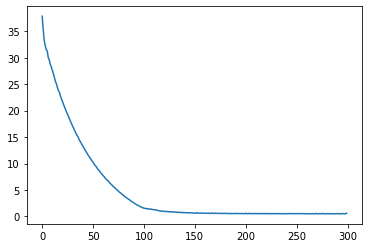

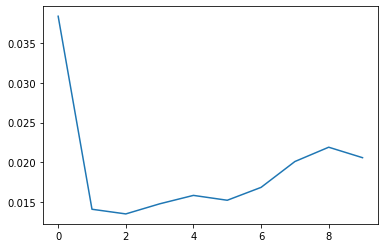

In [33]:
plt.figure()
plt.plot(Train_Loss)
plt.figure()
plt.plot(Test_Loss)


In [37]:
        for drop_prob in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]:
        # for drop_prob in [0.3]:

            with torch.no_grad():
                model.eval()
                for (XX,YY, M) in test_loader:
                    Temp_mask = np.random.rand(XX.size(0),XX.size(1),XX.size(2))
                    Mask_matrix = torch.Tensor((Temp_mask > drop_prob) + 0.0)
                    XX_in = XX*M*Mask_matrix
                    XX_in = XX_in.to(device)
                    XX = XX.to(device)
                    M = M.to(device) 
                    Mask_matrix = Mask_matrix.to(device)
                    # mu,lnvar,re_x,D_fake,log_det = model(torch.zeros_like(XX_in).to(device),eval_flag = 1)
                    # mu,lnvar,re_x,D_fake,log_det = model(torch.rand_like(XX_in),eval_flag = 1)                    
                    re_x,_ = model(XX_in,M*Mask_matrix)
                    MSE_loss = (F.mse_loss(re_x*(1-Mask_matrix)*M, XX*(1-Mask_matrix)*M) /(drop_prob)).cpu().detach().numpy() 
                    RMSE_loss = (MSE_loss)**(0.5)
                    MAE_loss = (torch.sum(torch.abs((re_x-XX)*(1-Mask_matrix)*M) )/  ((1-Mask_matrix).sum())).cpu().detach().numpy().item()
                    print('drop rate',drop_prob,'MSE loss', MSE_loss, 'RMSE loss', RMSE_loss, 'MAE loss', MAE_loss)

drop rate 0.1 MSE loss 0.016354768 RMSE loss 0.12788576 MAE loss 0.07177239656448364
drop rate 0.2 MSE loss 0.020902816 RMSE loss 0.14457807 MAE loss 0.08359671384096146
drop rate 0.3 MSE loss 0.025844771 RMSE loss 0.16076308 MAE loss 0.09571508318185806
drop rate 0.4 MSE loss 0.03197879 RMSE loss 0.17882614 MAE loss 0.10905902832746506
drop rate 0.5 MSE loss 0.039306056 RMSE loss 0.19825755 MAE loss 0.12245550006628036
drop rate 0.6 MSE loss 0.04722548 RMSE loss 0.21731424 MAE loss 0.13564172387123108
drop rate 0.7 MSE loss 0.056306023 RMSE loss 0.2372889 MAE loss 0.1492549628019333
drop rate 0.8 MSE loss 0.068177134 RMSE loss 0.2611075 MAE loss 0.16585758328437805
drop rate 0.9 MSE loss 0.07991445 RMSE loss 0.28269145 MAE loss 0.18061213195323944
drop rate 0.95 MSE loss 0.08674334 RMSE loss 0.29452223 MAE loss 0.1886696219444275
drop rate 0.99 MSE loss 0.09198373 RMSE loss 0.3032882 MAE loss 0.19474387168884277


In [24]:
        for drop_prob in [0.3]:
        # for drop_prob in [0.3]:

            with torch.no_grad():
                model.eval()
                for (XX,YY, M) in test_loader:
                    Temp_mask = np.random.rand(XX.size(0),XX.size(1),XX.size(2))
                    Mask_matrix = torch.Tensor((Temp_mask > drop_prob) + 0.0)
                    XX_in = XX*M*Mask_matrix
                    XX_in = XX_in.to(device)
                    XX = XX.to(device)
                    M = M.to(device) 
                    Mask_matrix = Mask_matrix.to(device)
                    # mu,lnvar,re_x,D_fake,log_det = model(torch.zeros_like(XX_in).to(device),eval_flag = 1)
                    # mu,lnvar,re_x,D_fake,log_det = model(torch.rand_like(XX_in),eval_flag = 1)                    
                    re_x,_ = model(XX_in,M*Mask_matrix)
                    MSE_loss = (F.mse_loss(re_x*(1-Mask_matrix)*M, XX*(1-Mask_matrix)*M) /(drop_prob)).cpu().detach().numpy() 
                    RMSE_loss = (MSE_loss)**(0.5)
                    MAE_loss = (torch.sum(torch.abs((re_x-XX)*(1-Mask_matrix)*M) )/  ((1-Mask_matrix).sum())).cpu().detach().numpy().item()
                    print('drop rate',drop_prob,'MSE loss', MSE_loss, 'RMSE loss', RMSE_loss, 'MAE loss', MAE_loss)

# plt.figure(figsize=[20,20])
# for i_cat in range(100):
#     plt.subplot(10,10,i_cat+1)
#     plt.scatter(range(time_step), XX[0][i_cat,:].cpu().detach().numpy())
#     plt.scatter(range(time_step), XX_in[0][i_cat,:].cpu().detach().numpy())
#     plt.plot(re_x[0][i_cat,:].cpu().detach().numpy())

drop rate 0.3 MSE loss 0.024730004 RMSE loss 0.15725777 MAE loss 0.09535637497901917


In [25]:
re_x[re_x < 0] = 0
X_pred = XX_in + re_x * (1- M*Mask_matrix)

XX = XX.cpu().detach().numpy()
XX_in = XX_in.cpu().detach().numpy()
re_x = re_x.cpu().detach().numpy()
X_pred = X_pred.cpu().detach().numpy()
M = M.cpu().detach().numpy()
Mask_matrix = Mask_matrix.cpu().detach().numpy()
M_nan = M*Mask_matrix
M_nan[M_nan==0] = np.nan

In [26]:
location_ID, Shuxing_ID

(['Daxing',
  'Fengtaihuayuan',
  'Fangshan',
  'Huairou',
  'Pinggu',
  'Pingchang',
  'Miyun',
  'Tongzhou',
  'Shunyi',
  'Yanqin',
  'Mentougou'],
 ['CO',
  'NO2',
  'O3',
  'PM2.5',
  'PM10',
  'SO2',
  'Humidity',
  'Pressure',
  'Temperature',
  'Wind Direction',
  'Wind Speed'])

In [27]:
10//11

0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

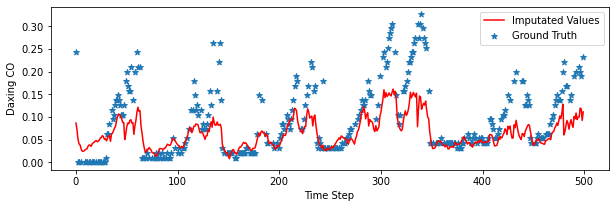

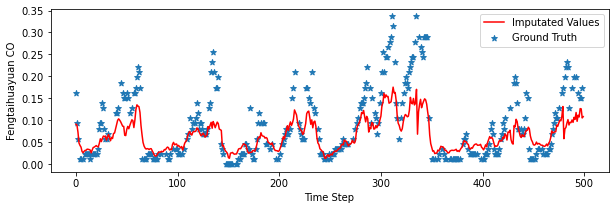

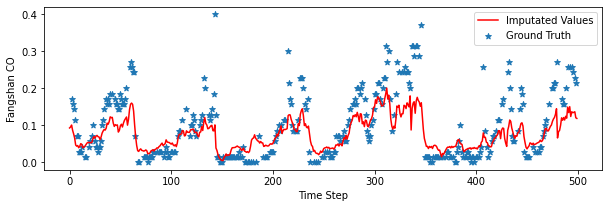

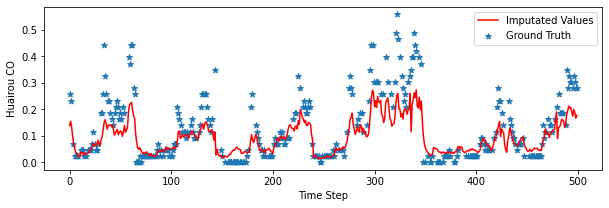

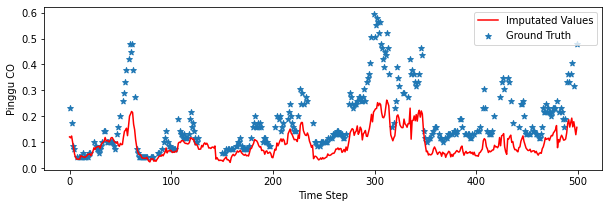

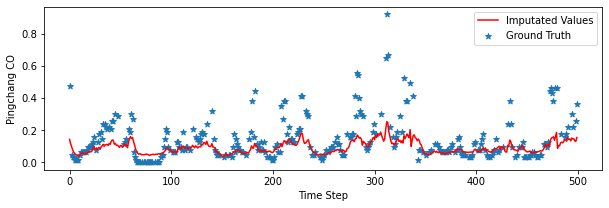

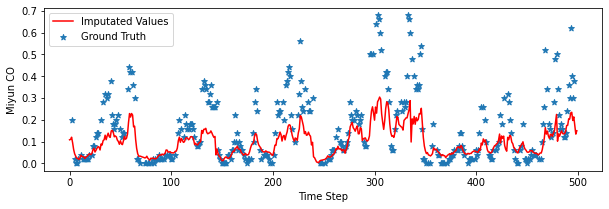

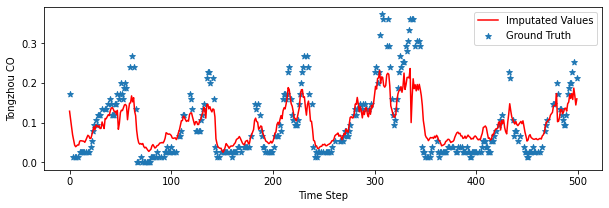

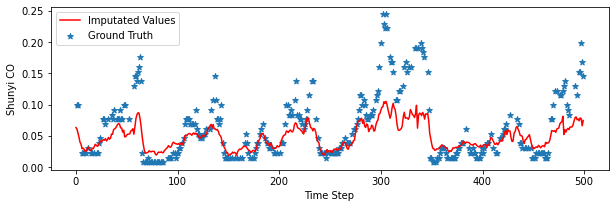

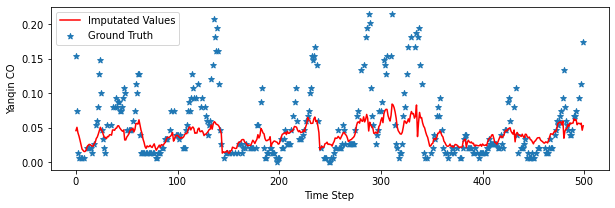

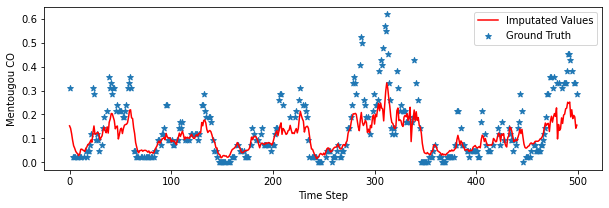

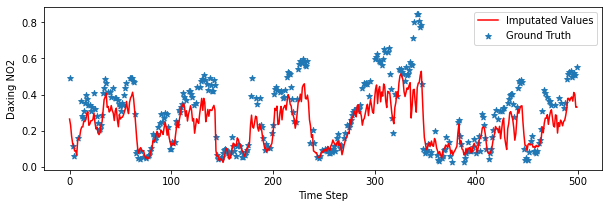

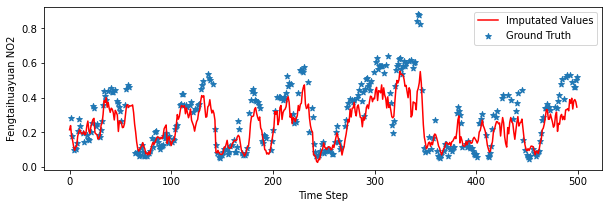

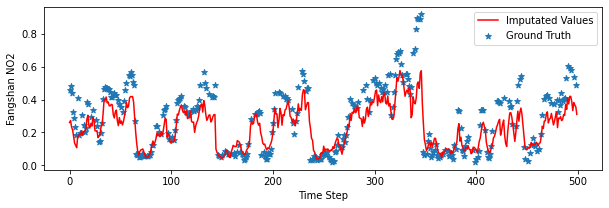

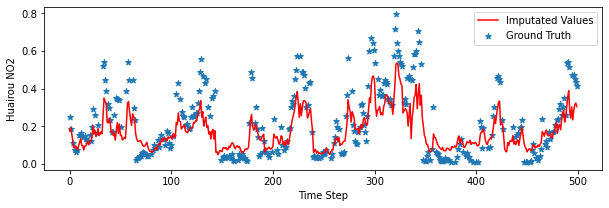

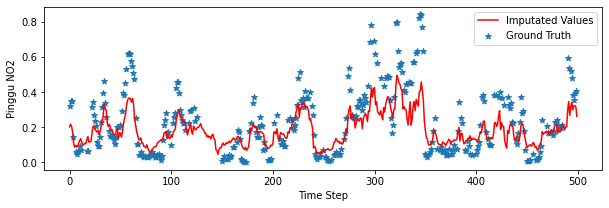

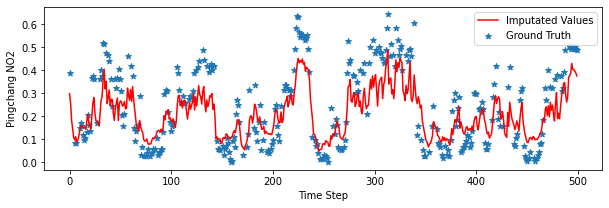

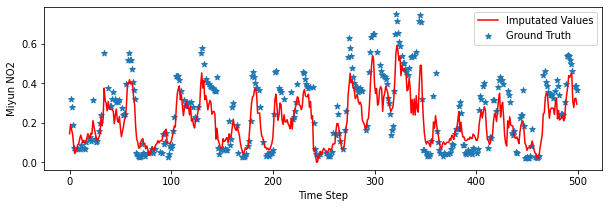

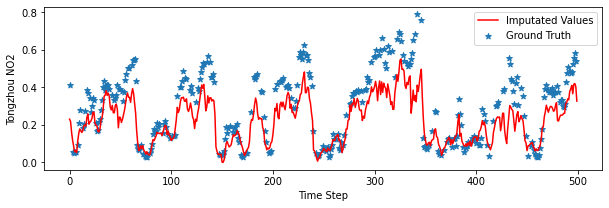

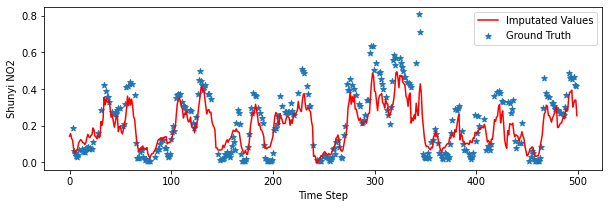

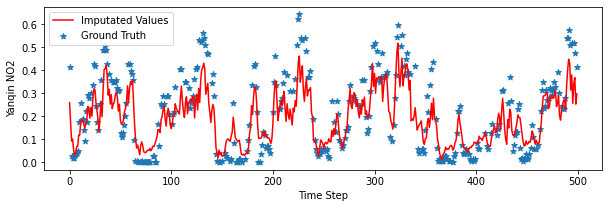

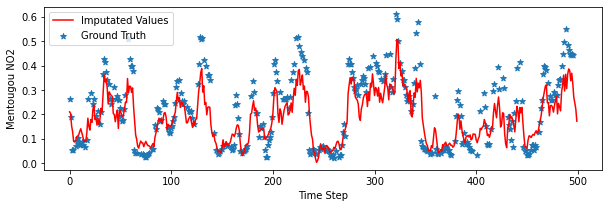

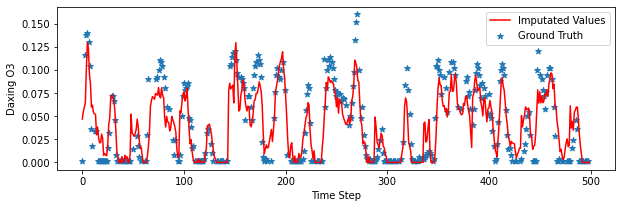

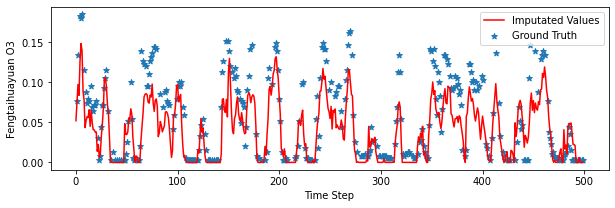

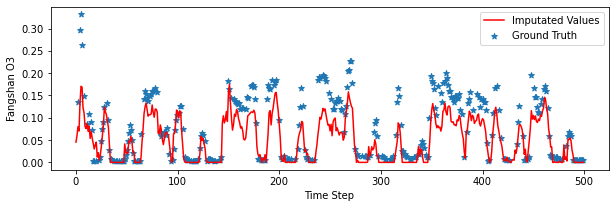

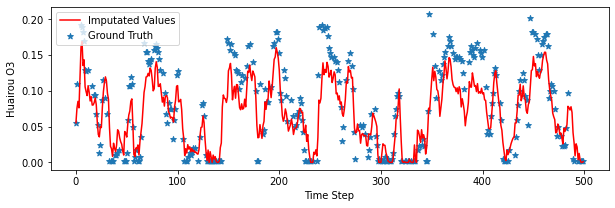

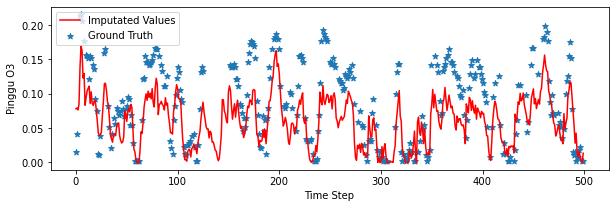

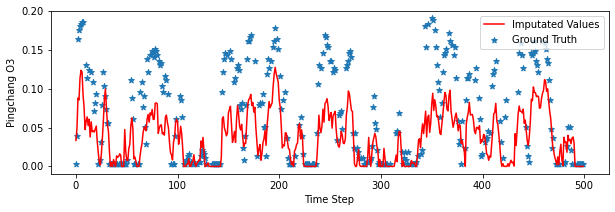

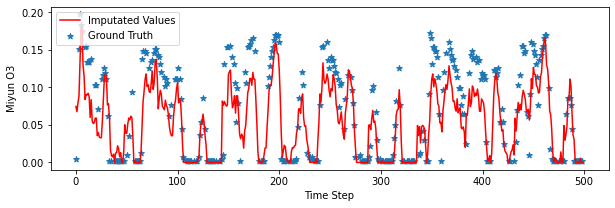

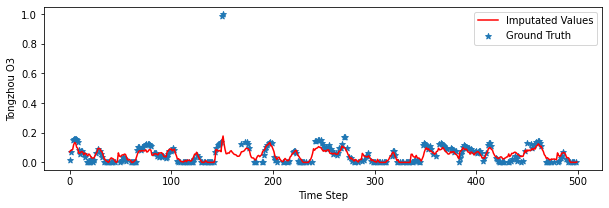

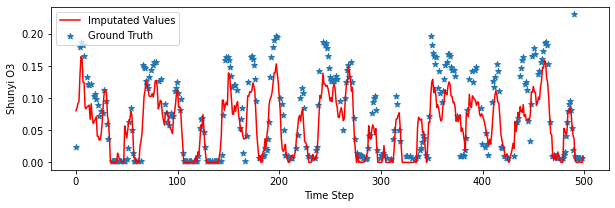

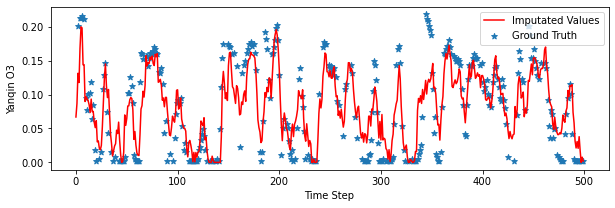

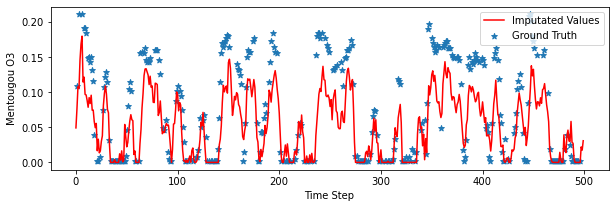

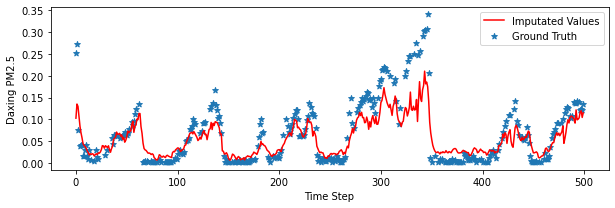

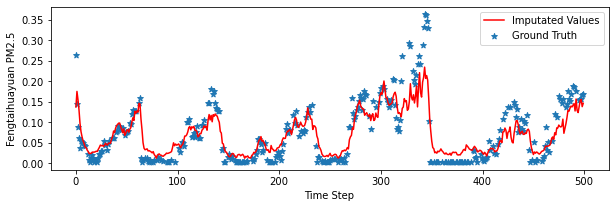

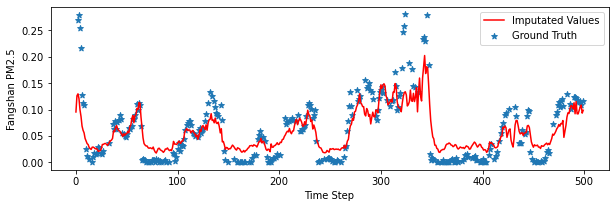

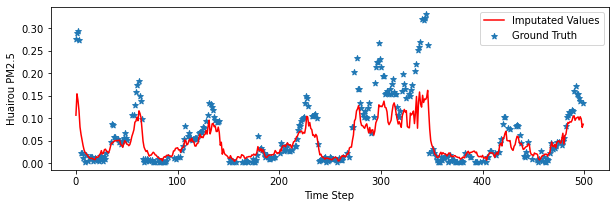

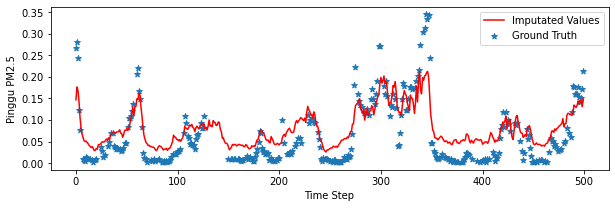

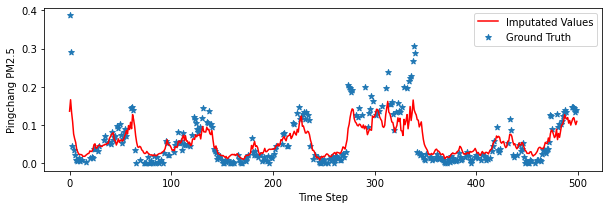

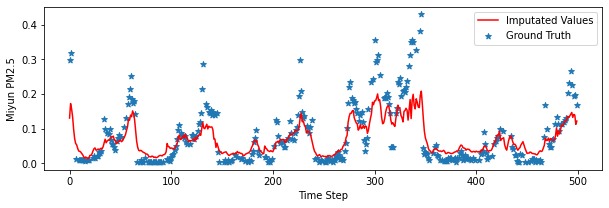

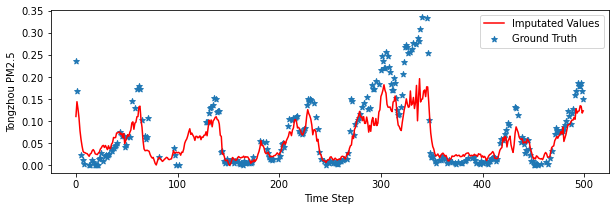

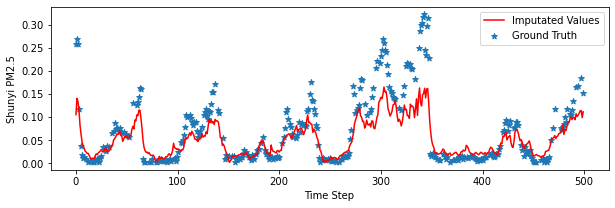

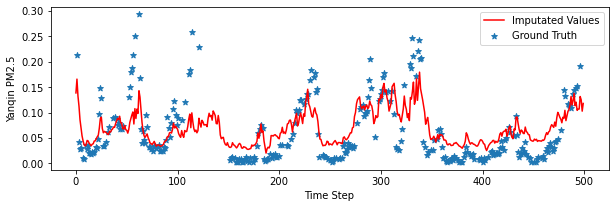

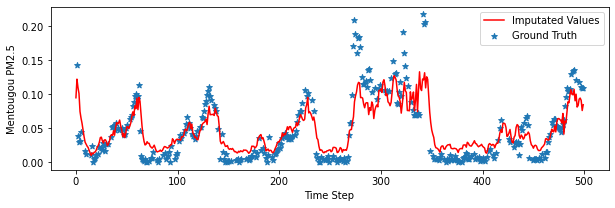

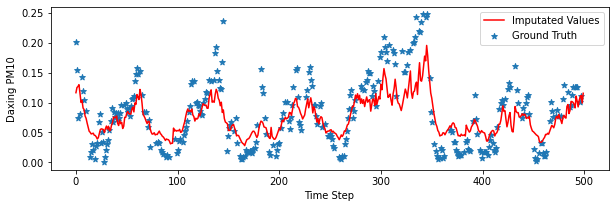

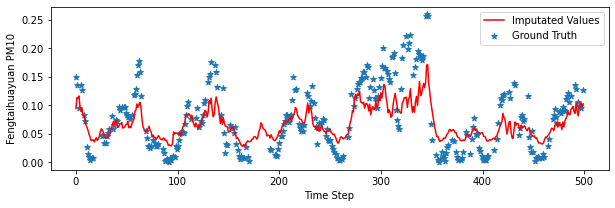

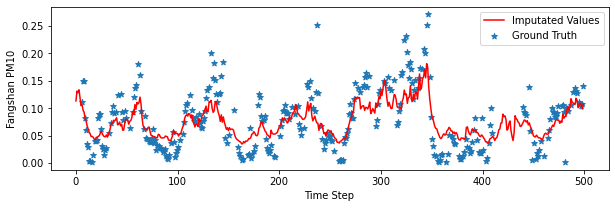

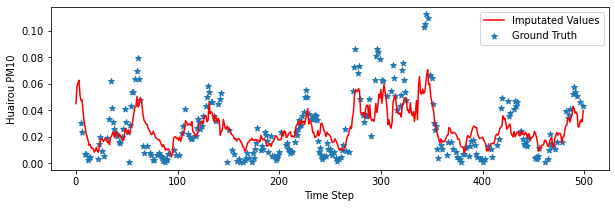

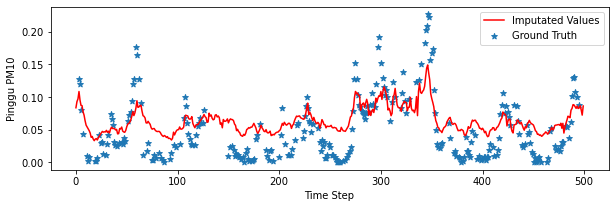

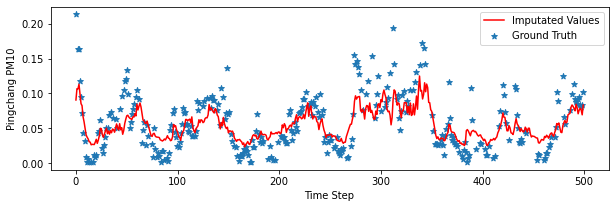

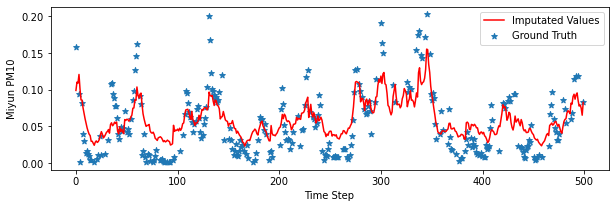

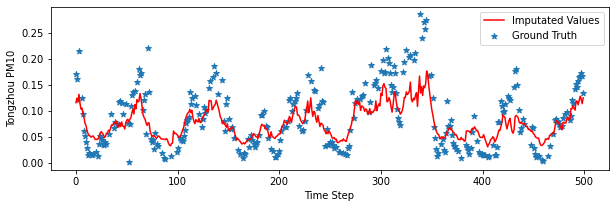

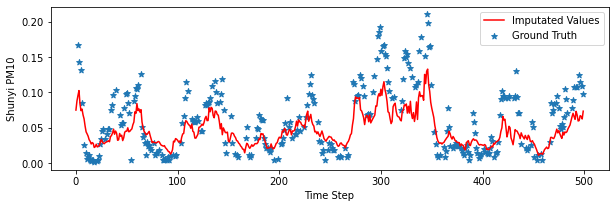

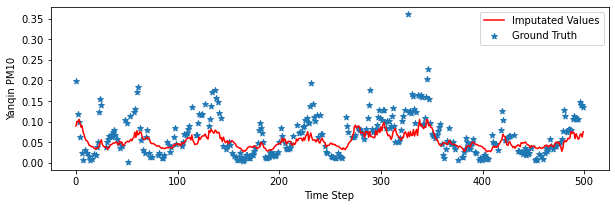

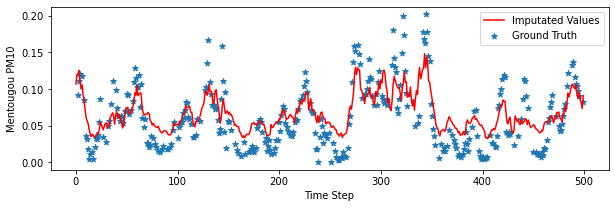

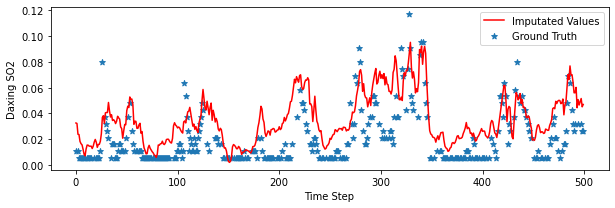

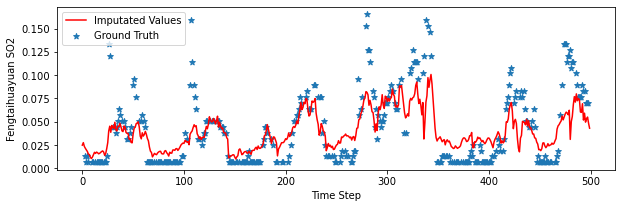

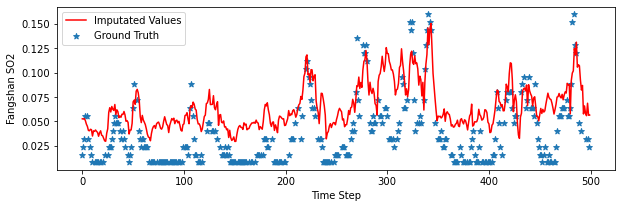

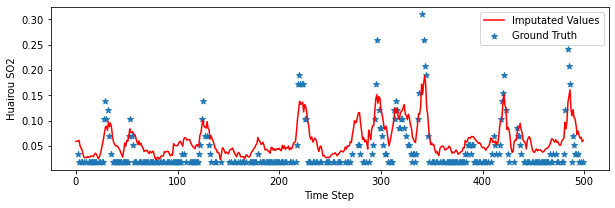

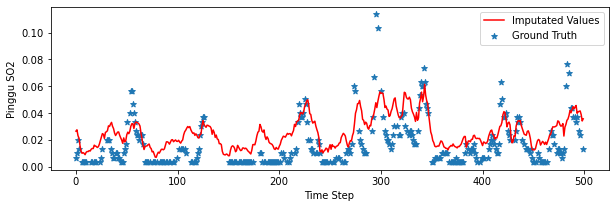

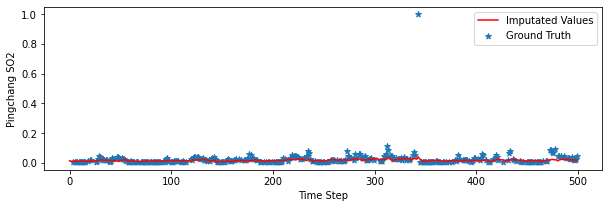

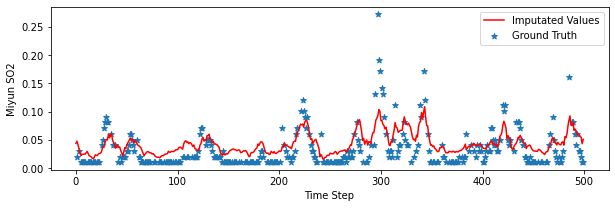

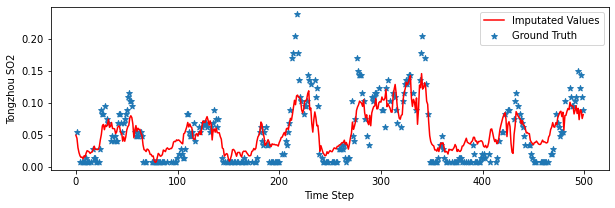

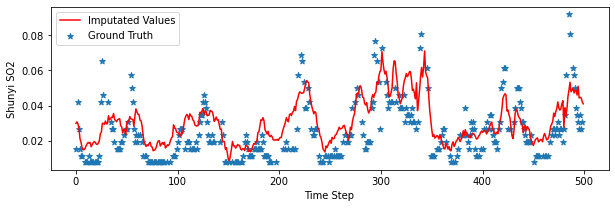

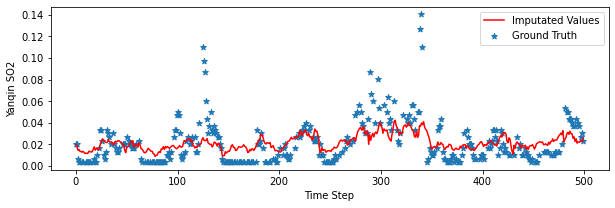

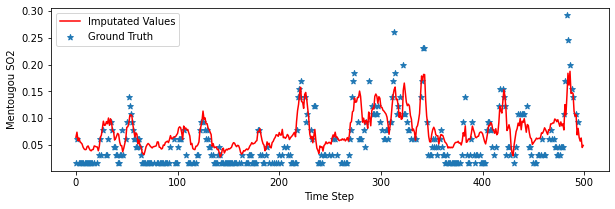

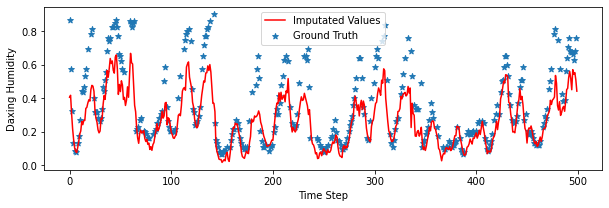

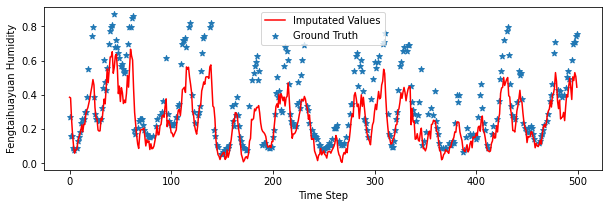

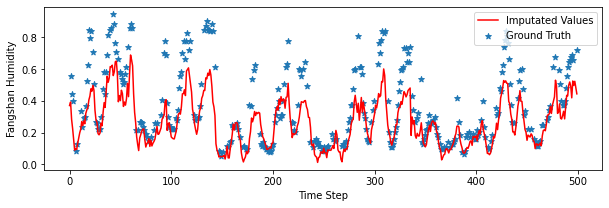

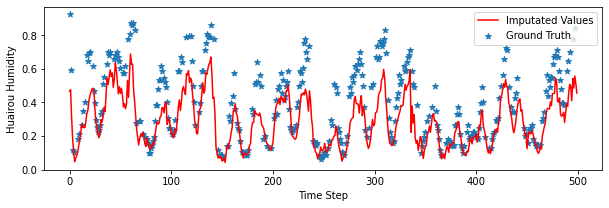

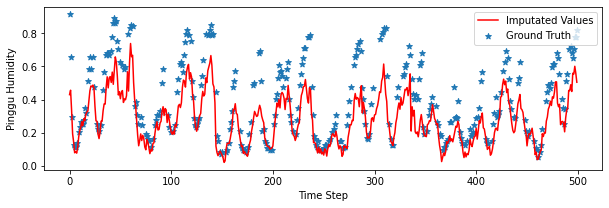

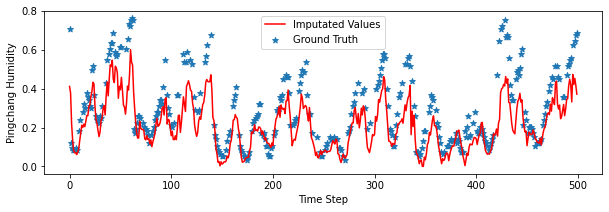

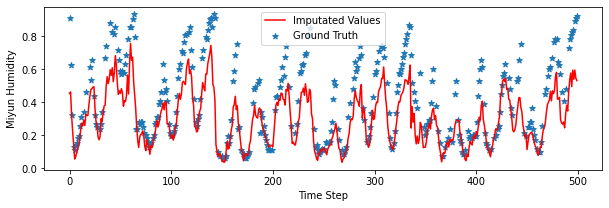

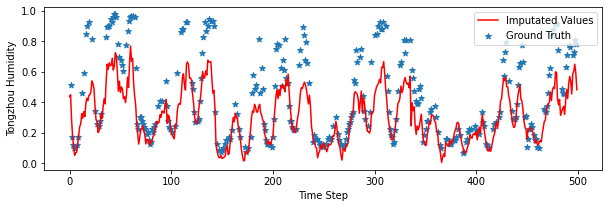

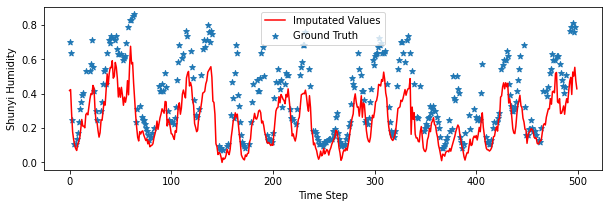

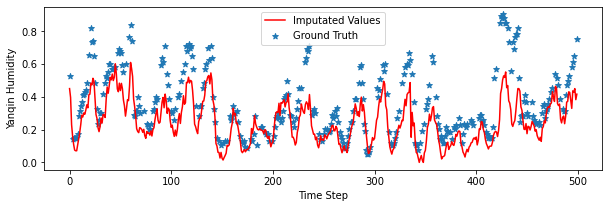

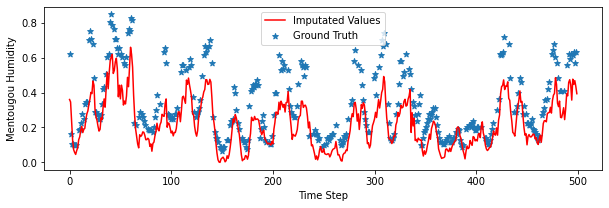

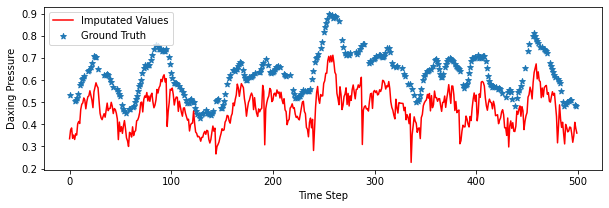

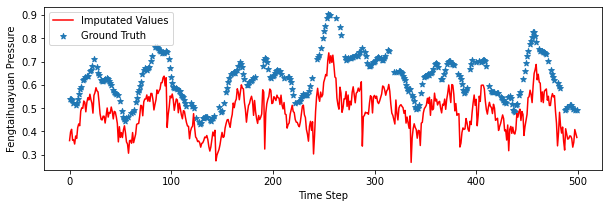

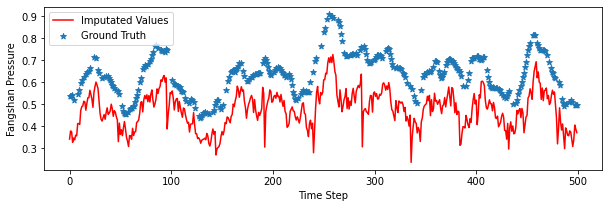

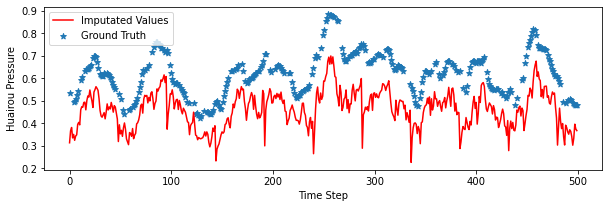

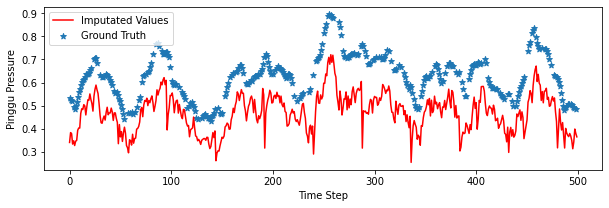

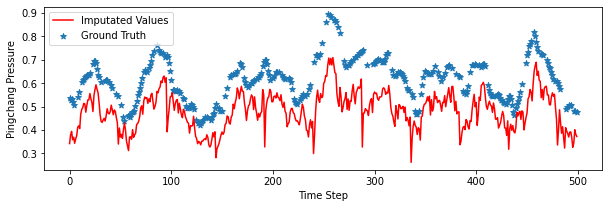

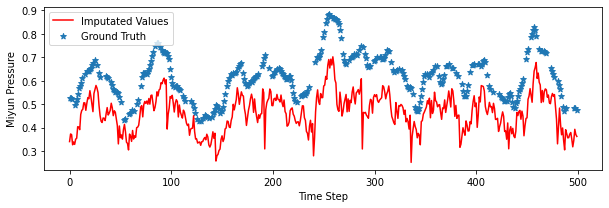

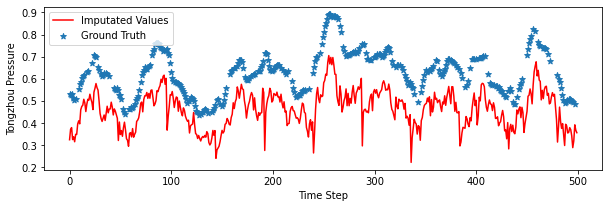

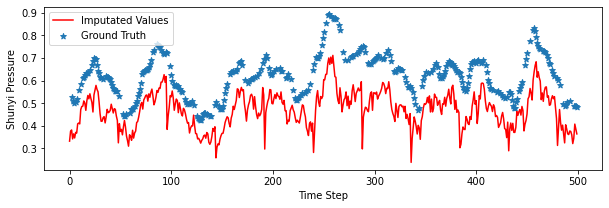

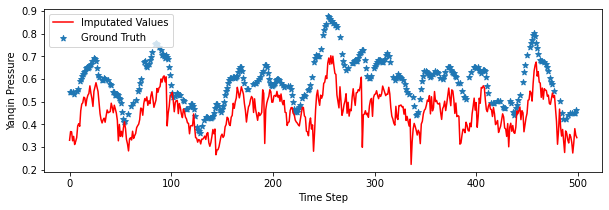

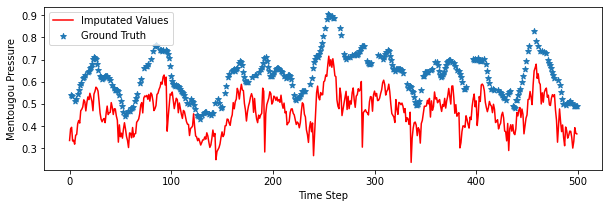

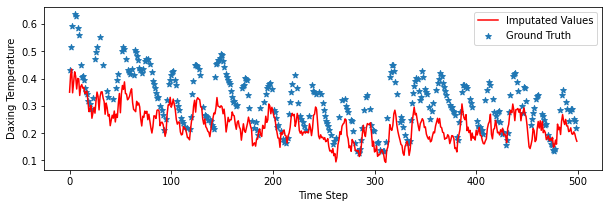

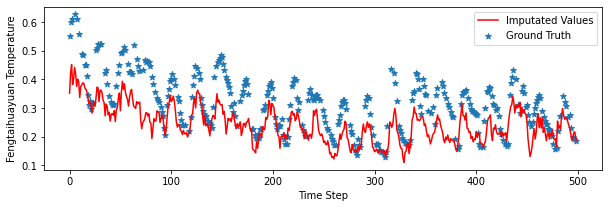

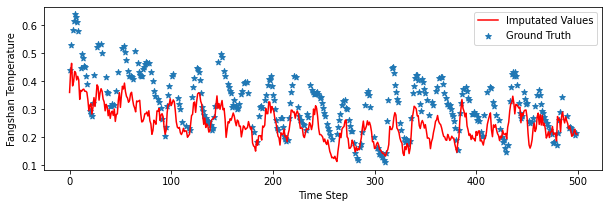

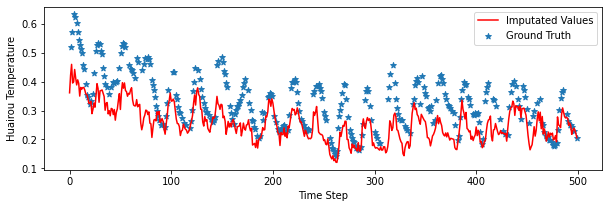

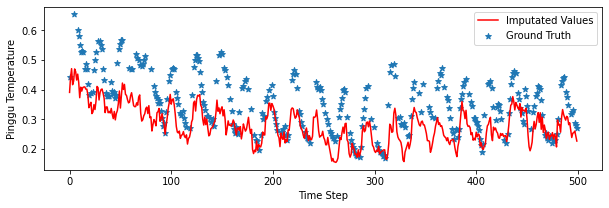

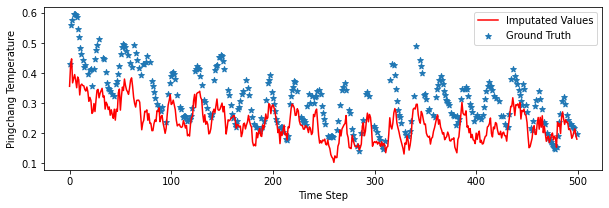

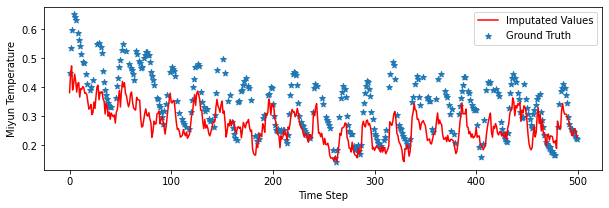

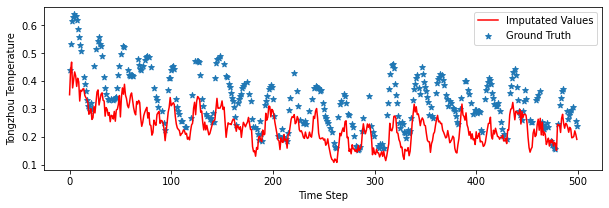

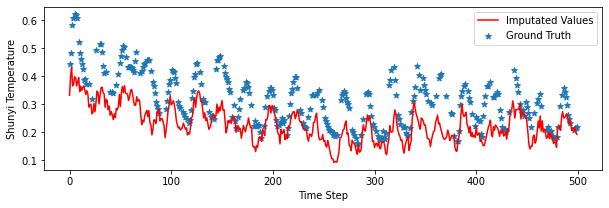

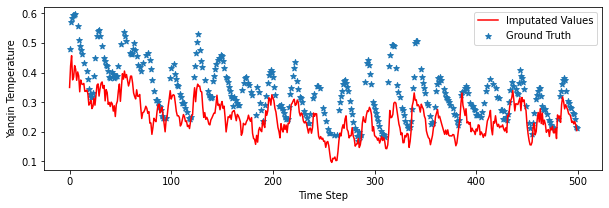

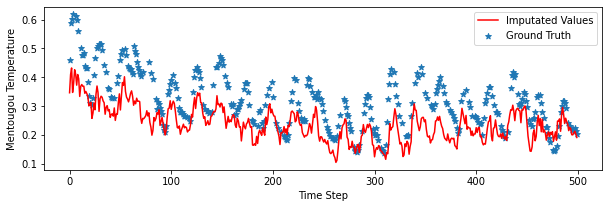

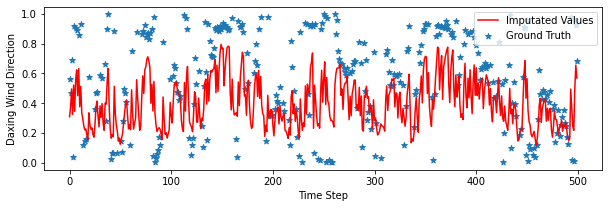

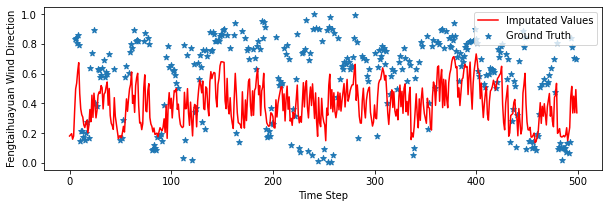

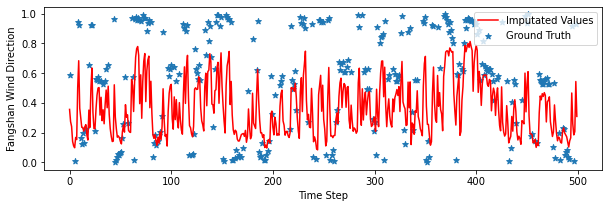

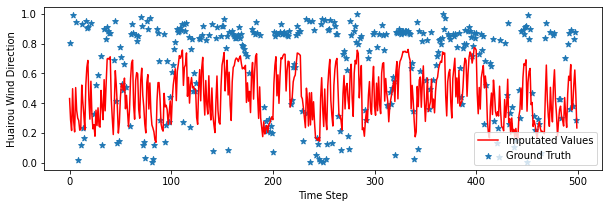

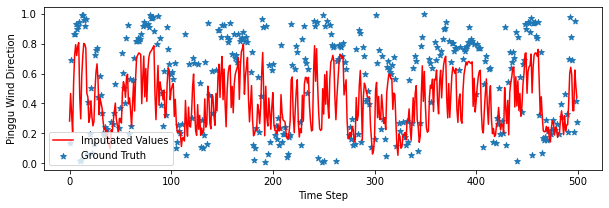

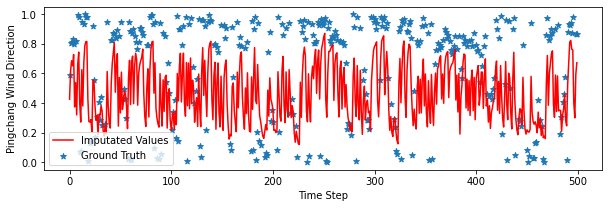

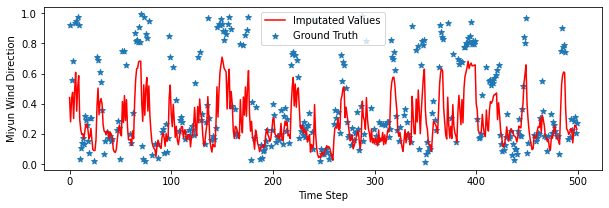

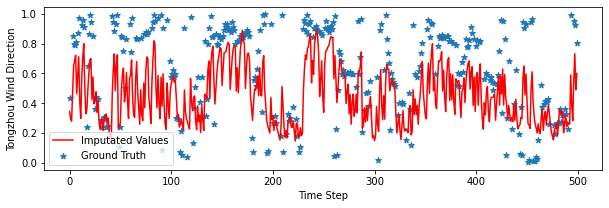

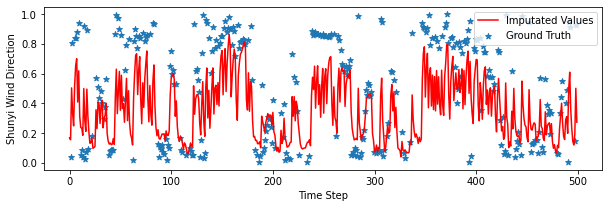

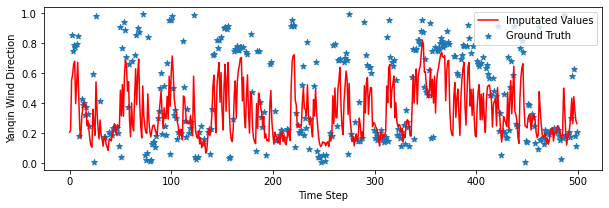

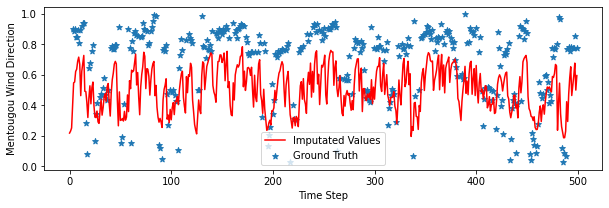

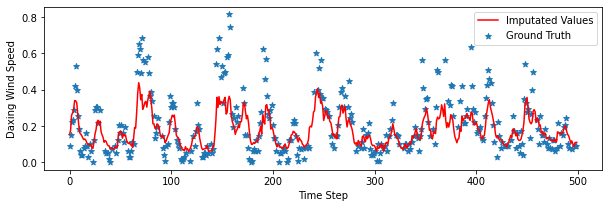

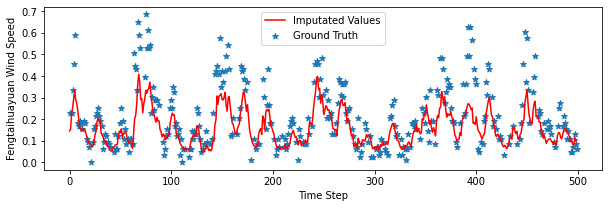

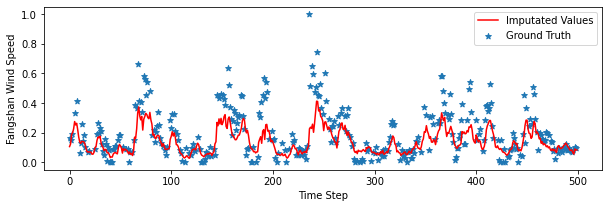

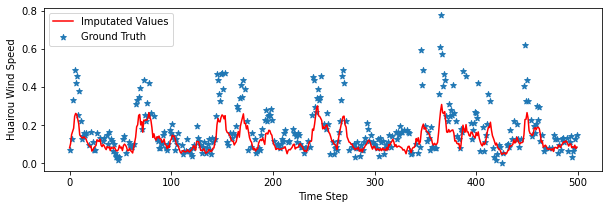

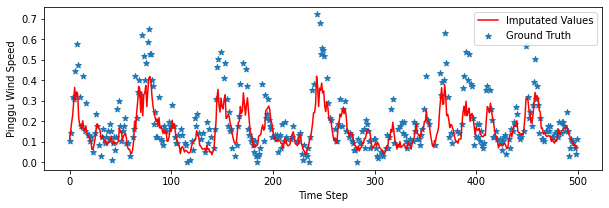

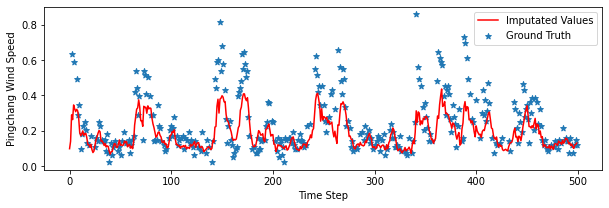

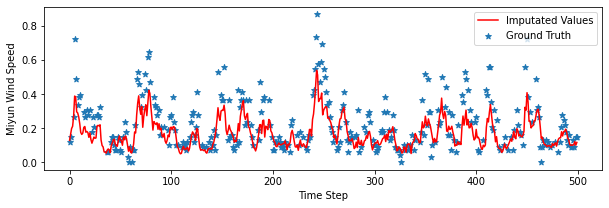

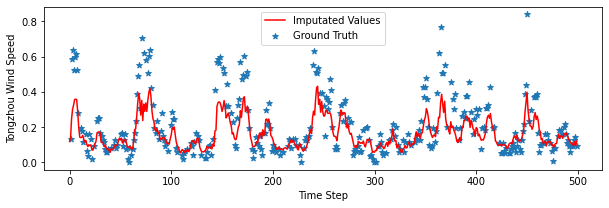

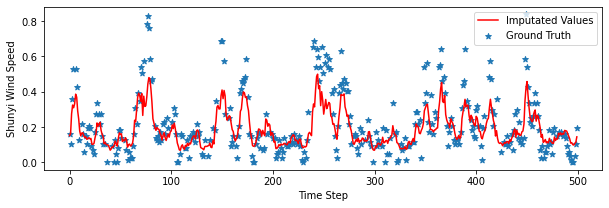

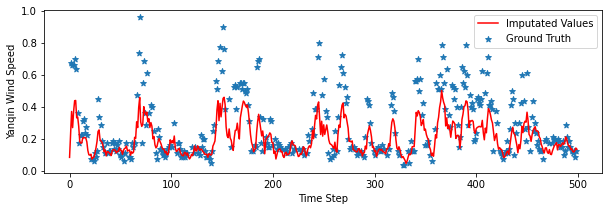

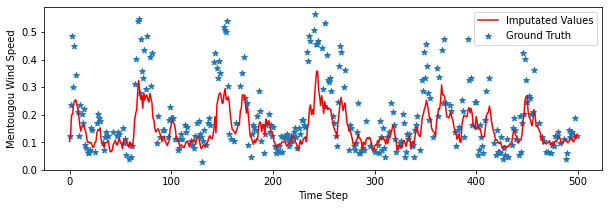

In [28]:
plot_len = 500
for i_plot_char in range(0,121,1):
    plot_char = i_plot_char

    # plot_temp = [XX[i,plot_char,:] for  i in range(XX.shape[0])]
    # plot_temp = np.array(plot_temp).reshape(-1)
    # plot_temp = plot_temp[0:plot_len]
    # plt.figure(figsize=(30,2))
    # plt.scatter(range(plot_temp.shape[0]), plot_temp, marker='*')

    plot_temp = [(XX_in*M_nan)[i,plot_char,:] for  i in range(XX_in.shape[0])]
    plot_temp = np.array(plot_temp).reshape(-1)
    plot_temp = plot_temp[0:plot_len]
    plt.figure(figsize=(10,3))
    plt.scatter(range(plot_temp.shape[0]), plot_temp, marker='*', label= 'Ground Truth')
    plt.legend()

    plot_temp = [re_x[i,plot_char,:] for  i in range(re_x.shape[0])]
    plot_temp = np.array(plot_temp).reshape(-1)
    plot_temp = plot_temp[0:plot_len]
    # plt.figure(figsize=(30,2))
    plt.plot(range(plot_temp.shape[0]), plot_temp, 'r', label = 'Imputated Values')  #,marker='*'
    plt.legend()

    shuxing_num = i_plot_char//11
    location_num = i_plot_char%11
    str_title =  location_ID[location_num] + ' ' + Shuxing_ID[shuxing_num]  #
    plt.ylabel(str_title)
    plt.xlabel('Time Step')
    plt.savefig('./saved_fig/imputation_'+str(i_plot_char)+'.eps', bbox_inches = 'tight')

In [29]:
clstm.GC(threshold = False) 

tensor([[0.0039, 0.0022, 0.0035,  ..., 0.0016, 0.0011, 0.0019],
        [0.0024, 0.0028, 0.0029,  ..., 0.0020, 0.0018, 0.0025],
        [0.0027, 0.0025, 0.0022,  ..., 0.0026, 0.0023, 0.0012],
        ...,
        [0.0024, 0.0015, 0.0021,  ..., 0.0030, 0.0037, 0.0032],
        [0.0016, 0.0013, 0.0028,  ..., 0.0021, 0.0018, 0.0025],
        [0.0026, 0.0023, 0.0025,  ..., 0.0024, 0.0020, 0.0022]],
       device='cuda:0', grad_fn=<StackBackward>)

In [93]:
GC_est = clstm.GC(threshold = False).cpu().data.numpy()
# GC_est[GC_est<0.08] = 0
# GC_est[GC_est>0.08] = 1
GC_est = np.log(GC_est)
# GC_est[GC_est>-3] = 1

# GC_est[GC_est<-3] = 0
# GC_est[GC_est>-3] = 1

plt.figure(figsize=(10, 10))
plt.ylabel('Affected series', fontsize=20)
plt.xlabel('Causal series', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



# plt.imshow(np.log(GC_est), cmap='Blues', vmin=0, vmax=0.0000005, extent=(0, len(GC_est), len(GC_est), 0))
plt.imshow(GC_est, cmap='Blues')

# plt.colorbar()
plt.show()
plt.savefig('./saved_fig/Causal_Kdd.jpg', bbox_inches = 'tight')